In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import root_mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importamos los datasets preparados 

X_train = pd.read_pickle("dataset/processed_data/linear/Xlm_train.pkl")
X_test = pd.read_pickle("dataset/processed_data/linear/Xlm_test.pkl")
y_train = pd.read_pickle("dataset/processed_data/linear/ylm_train.pkl")
y_test = pd.read_pickle("dataset/processed_data/linear/ylm_test.pkl")

In [3]:
elastic_net = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 1],  # Mixing values (0=Ridge, 1=Lasso)
    alphas=np.logspace(-4, 2, 50),  # Range of alpha values
    cv=5,  # 5-fold cross-validation
    max_iter=10000,
    random_state=42
)

elastic_net.fit(X_train, y_train)

ElasticNetCV(alphas=array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04, 7.19685673e-04,
       9.54095476e-04, 1.26485522e-03, 1.67683294e-03, 2.22299648e-03,
       2.94705170e-03, 3.90693994e-03, 5.17947468e-03, 6.86648845e-03,
       9.10298178e-03, 1.20679264e-02, 1.59985872e-02, 2.12095089e-02,
       2.81176870e-02, 3.727593...
       2.68269580e-01, 3.55648031e-01, 4.71486636e-01, 6.25055193e-01,
       8.28642773e-01, 1.09854114e+00, 1.45634848e+00, 1.93069773e+00,
       2.55954792e+00, 3.39322177e+00, 4.49843267e+00, 5.96362332e+00,
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02]),
             cv=5, l1_ratio=[0.1, 0.5, 0.7, 1], max_iter=10000,
             random_state=42)

In [4]:
importancia_predictores = pd.Series(elastic_net.coef_, index=X_train.columns) 
print(importancia_predictores)

MSSubClass      0.000000
LotFrontage    -0.007575
LotArea         0.048728
OverallQual     0.087859
OverallCond     0.045880
                  ...   
GarageFinish    0.010492
GarageQual      0.012164
GarageCond      0.000000
Neighborhood    0.000000
ExterCond      -0.000000
Length: 137, dtype: float64


In [5]:
predictores_elegidos = importancia_predictores[abs(importancia_predictores) > 0.01].index
print(predictores_elegidos)


Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'HalfBath', 'KitchenAbvGr',
       'GarageYrBlt', 'GarageCars', 'MSZoning_RM', 'LotShape_IR3',
       'LandContour_HLS', 'LotConfig_CulDSac', 'LandSlope_Mod',
       'Condition1_Norm', 'HouseStyle_SFoyer', 'RoofStyle_Gable',
       'Exterior1st_BrkFace', 'MasVnrType_Stone', 'Foundation_PConc',
       'Foundation_Slab', 'PavedDrive_Y', 'MasVnrType_Stone', 'ExterQual',
       'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual'],
      dtype='object')


In [6]:
print(len(predictores_elegidos))

31


In [7]:
joblib.dump(predictores_elegidos, "modelos/elastic_net/predictores_elastic_net.pkl")

['modelos/elastic_net/predictores_elastic_net.pkl']

In [8]:
predicciones_en = elastic_net.predict(X_test)


In [9]:
rmse = root_mean_squared_error(y_test, predicciones_en)
r2 = r2_score(y_test, predicciones_en)

In [10]:
print(f"✅ Desempeno Elastic Net:")
print(f"Test RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

✅ Desempeno Elastic Net:
Test RMSE: 0.15
R² Score: 0.881


In [11]:
predicciones_real = np.expm1(predicciones_en)  
y_test_real = np.expm1(y_test)

In [12]:
rmse_real = root_mean_squared_error(y_test_real, predicciones_real)
print(rmse_real)

31935.901464006194


In [13]:
margen_error = (rmse_real / y_test_real.mean()) * 100

In [14]:
print(margen_error)

17.85726632703428


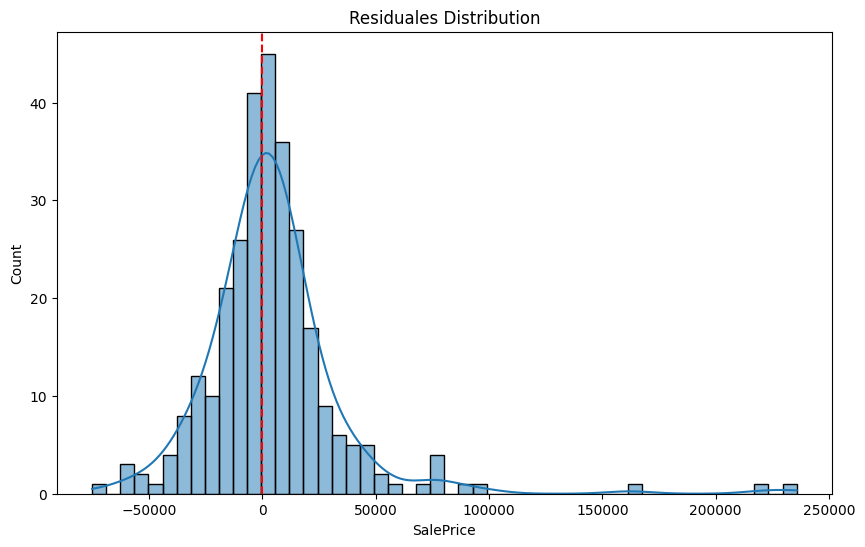

In [15]:
# Analisis del rendimiento 

residuales = y_test_real - predicciones_real

plt.figure(figsize=(10,6))
sns.histplot(residuales, bins=50, kde=True)
plt.axvline(x=0, color='red', linestyle='dashed')
plt.title("Residuales Distribution")
plt.show()

In [16]:
df_resultados1 = pd.DataFrame({"Real": y_test_real, "Predicciones": predicciones_real, "Residuales": residuales})
df_resultados1.sort_values(by="Residuales", ascending=False).head(10)


,Real,Predicciones,Residuales
691,755000.0,519258.029407,235741.970593
898,611657.0,389922.775513,221734.224487
1046,556581.0,394597.980134,161983.019866
774,395000.0,296547.034652,98452.965348
1243,465000.0,374691.758760,90308.241240
231,403000.0,323761.018870,79238.981130
591,451950.0,375585.057064,76364.942936
585,369900.0,294021.464691,75878.535309
218,311500.0,235959.357357,75540.642643
718,341000.0,268643.053545,72356.946455


In [17]:
importancia_predictores = pd.Series(elastic_net.coef_, index=X_train.columns).sort_values(ascending=False)
print(importancia_predictores.head(20))


GrLivArea              0.132040
OverallQual            0.087859
Exterior1st_BrkFace    0.063900
YearBuilt              0.055872
Condition1_Norm        0.049940
LotArea                0.048728
OverallCond            0.045880
1stFlrSF               0.041688
LandContour_HLS        0.041530
Functional             0.041472
GarageCars             0.037739
KitchenQual            0.032741
Foundation_PConc       0.030628
LandSlope_Mod          0.022574
ExterQual              0.020289
YearRemodAdd           0.019101
PavedDrive_Y           0.016810
LotConfig_CulDSac      0.016099
HalfBath               0.014408
HouseStyle_SFoyer      0.012760
dtype: float64


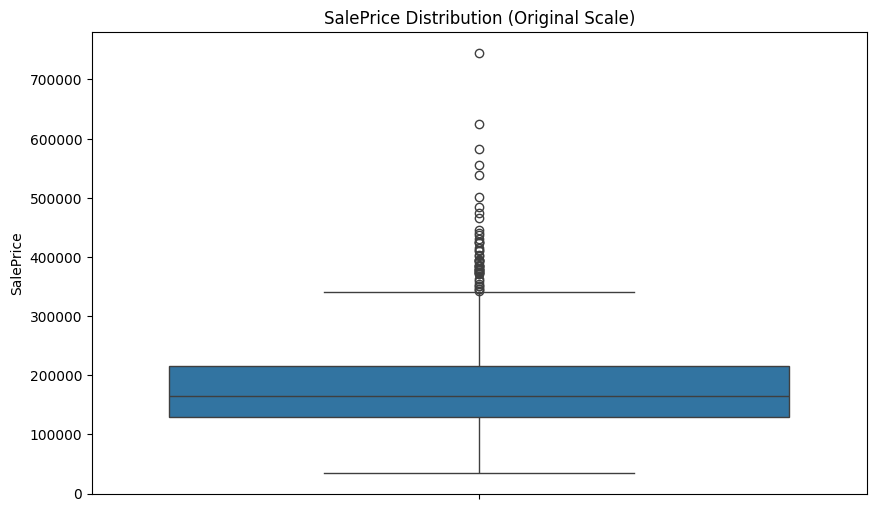

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(y=np.expm1(y_train))  # Reverse log transformation
plt.title("SalePrice Distribution (Original Scale)")
plt.show()

In [19]:
df_train_results = pd.DataFrame({"SalePrice": np.expm1(y_train)})
df_train_results["Z-Score"] = (df_train_results["SalePrice"] - df_train_results["SalePrice"].mean()) / df_train_results["SalePrice"].std()
df_train_results.sort_values(by="SalePrice", ascending=False).head(20)  # Check highest prices


,SalePrice,Z-Score
1182,745000.0,7.293973
1169,625000.0,5.740848
803,582933.0,5.196387
440,555000.0,4.834858
769,538000.0,4.614832
178,501837.0,4.146785
798,485000.0,3.928868
185,475000.0,3.799441
1373,466500.0,3.689428
527,446261.0,3.427481


In [20]:
upper_limit = np.expm1(y_train).quantile(0.99)  # Top 1%

# Filter out extreme expensive homes
y_train_filtered = y_train[np.expm1(y_train) < upper_limit]
X_train_filtered = X_train.loc[y_train_filtered.index] 

In [21]:
elastic_net2 = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 1],  # Mixing values (0=Ridge, 1=Lasso)
    alphas=np.logspace(-4, 2, 50),  # Range of alpha values
    cv=5,  # 5-fold cross-validation
    max_iter=10000,
    random_state=42
)

elastic_net2.fit(X_train_filtered, y_train_filtered)

ElasticNetCV(alphas=array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04, 7.19685673e-04,
       9.54095476e-04, 1.26485522e-03, 1.67683294e-03, 2.22299648e-03,
       2.94705170e-03, 3.90693994e-03, 5.17947468e-03, 6.86648845e-03,
       9.10298178e-03, 1.20679264e-02, 1.59985872e-02, 2.12095089e-02,
       2.81176870e-02, 3.727593...
       2.68269580e-01, 3.55648031e-01, 4.71486636e-01, 6.25055193e-01,
       8.28642773e-01, 1.09854114e+00, 1.45634848e+00, 1.93069773e+00,
       2.55954792e+00, 3.39322177e+00, 4.49843267e+00, 5.96362332e+00,
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02]),
             cv=5, l1_ratio=[0.1, 0.5, 0.7, 1], max_iter=10000,
             random_state=42)

In [22]:
predicciones2 = elastic_net2.predict(X_test)

In [23]:
predicciones2_reales = np.expm1(predicciones2)
rmse2_real = root_mean_squared_error(y_test_real, predicciones2_reales)
print(rmse2_real)

33670.119035374984


In [24]:
margen_error2 = (rmse2_real / y_test_real.mean()) * 100
print(margen_error2)

18.82697075438099
